# Simon’s Algorithm

Simon’s algorithm solves the following promise problem:  
Given black-box access to a function
$$ f:\{0,1\}^n \to \{0,1\}^m, $$
with the promise that there exists a secret string $s\in\{0,1\}^n$ such that
$$ f(x) = f(y) \;\;\Longleftrightarrow\;\; y = x \oplus s, $$
determine $s$.  

Classically, finding $s$ requires an exponential number of queries in $n$. Quantumly, Simon’s algorithm finds $s$ using only $O(n)$ queries, providing an **exponential speedup**. Historically, this was a precursor to Shor’s factoring algorithm.

---

## Oracle

The oracle $U_f$ acts as:
$$
U_f \, |x\rangle|0^m\rangle = |x\rangle|f(x)\rangle.
$$

Because $f(x)=f(x\oplus s)$, the mapping is **2-to-1**, and querying the oracle creates entanglement between the input and output registers. Measuring the output collapses the input into a superposition of two states separated by $s$.

---

## Algorithm

1. **Initialization**  
   Start with $n$ input qubits and $m$ output qubits in
   $$
   |0^n\rangle \otimes |0^m\rangle.
   $$

2. **Hadamards on inputs**  
   Apply $H^{\otimes n}$ to create a uniform superposition:
   $$
   \frac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}|x\rangle \otimes |0^m\rangle.
   $$

3. **Oracle query**  
   Apply $U_f$:
   $$
   \frac{1}{\sqrt{2^n}}\sum_{x}|x\rangle|f(x)\rangle.
   $$

   Measuring the second register gives some $f(x_0)$, collapsing the first register into:
   $$
   \frac{1}{\sqrt{2}}\left(|x_0\rangle + |x_0\oplus s\rangle\right).
   $$

4. **Hadamards on inputs**  
   Apply $H^{\otimes n}$ to the superposition. The resulting state has support only on strings $y$ satisfying:
   $$
   y \cdot s = 0 \pmod{2}.
   $$

5. **Measurement**  
   Measure the $n$ input qubits. Each run yields a random string $y$ orthogonal to $s$.

6. **Classical post-processing**  
   Repeat the procedure $O(n)$ times to collect $n-1$ independent equations of the form $y \cdot s = 0$. Solve the resulting linear system over $\mathbb{F}_2$ to recover the secret string $s$.

---

## Circuit Structure

- **Input register ($n$ qubits):**  
  Initialized to $|0^n\rangle$, Hadamard layer, then Hadamards again after the oracle.

- **Output register ($m$ qubits):**  
  Initialized to $|0^m\rangle$, filled with $f(x)$ by the oracle. Often measured and discarded.

- **Oracle $U_f$:**  
  Implemented as a reversible mapping $|x,0^m\rangle \mapsto |x,f(x)\rangle$. For toy cases, can be encoded using CNOT networks defined by a binary matrix.

---

## Complexity

- **Quantum:** $O(n)$ queries to $U_f$, plus Gaussian elimination in classical post-processing.  
- **Classical:** $\Omega(2^{n/2})$ queries required.  
- **Speedup:** Exponential.

---

## Key Insight

The **phase kickback** from the oracle combined with Hadamards enforces that every measurement outcome $y$ is orthogonal to the hidden string $s$. Collecting enough such equations uniquely determines $s$, showcasing the exponential advantage of quantum computation.



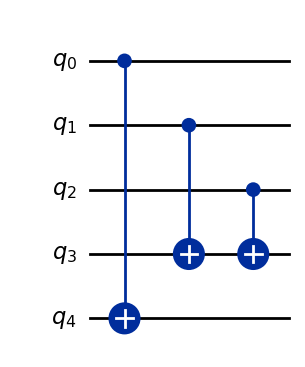

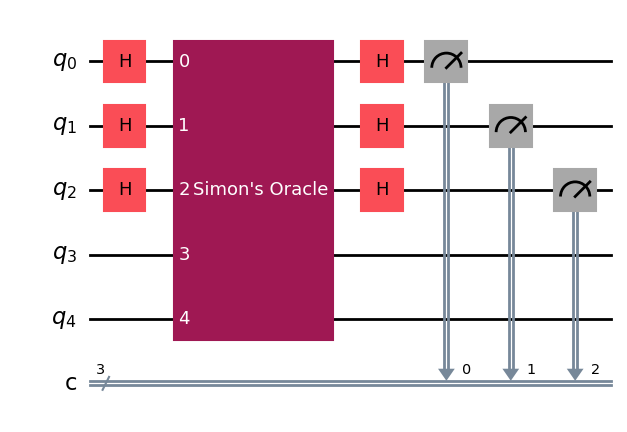

Counts: {'000': 9947, '111': 9860, '110': 10150, '001': 10043}


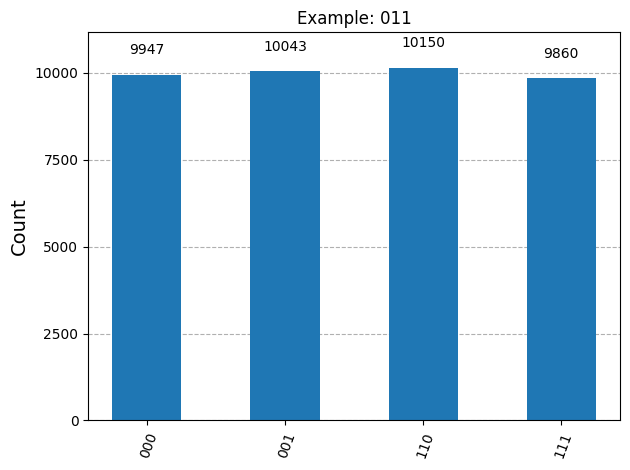

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Simon's algorithm circuit
def simon_algorithm(oracle):
    qc = QuantumCircuit(n + m, n)
    qc.h(list(range(n))) # Apply Hadamard gates to first n qubits
    qc.append(oracle, range(n + m))  # Apply oracle
    qc.h(list(range(n))) # Apply Hadamard gates to first n qubits
    qc.measure(range(n), range(n))
    return qc

def b_matrix_generator(case: str):
    if case == "100":
        # secret = 100 ⇒ rows orthogonal to (1,0,0)
        return [[0,1,0],
                [0,0,1]]  # kernel span{100}
    elif case == "010":
        # secret = 010 ⇒ rows orthogonal to (0,1,0)
        return [[1,0,0],
                [0,0,1]]  # kernel span{010}
    elif case == "001":
        # secret = 001 ⇒ rows orthogonal to (0,0,1)
        return [[1,0,0],
                [0,1,0]]  # kernel span{001}
    elif case == "110":
        # secret = 110 ⇒ need v·s = v0⊕v1 = 0
        return [[1,1,0],
                [0,0,1]]  # kernel span{110}
    elif case == "101":
        # secret = 101 ⇒ need v·s = v0⊕v2 = 0
        return [[1,0,1],
                [0,1,0]]  # kernel span{101}
    elif case == "011":
        # secret = 011 ⇒ need v·s = v1⊕v2 = 0
        return [[0,1,1],
                [1,0,0]]  # kernel span{011}
    elif case == "111":
        # secret = 111 ⇒ need v·s = v0⊕v1⊕v2 = 0
        return [[1,1,0],
                [0,1,1]]  # kernel span{111}
    else:
        raise ValueError("Only supports 3-bit secrets '100','010','001','110','101','011','111'")



# Simon's oracle generator
def simon_oracle(s: str):
    qc = QuantumCircuit(n + m, name="Simon's Oracle")

    b_matrix = b_matrix_generator(s)

    for i in range(n):
        for j in range(m):
            if b_matrix[j][i] == 1:
                qc.cx(i, n + j)
    return qc

# Example usage case = "011"
n = 3
m = 2
case = "011"

oracle = simon_oracle(case)
qc = simon_algorithm(oracle)
display(oracle.draw(output="mpl"))
display(qc.draw(output="mpl"))

# Run on simulator
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc, shots = 40000).result()
counts = result.get_counts()
print("Counts:", counts)
plot_histogram(counts, title="Example: "+ case)

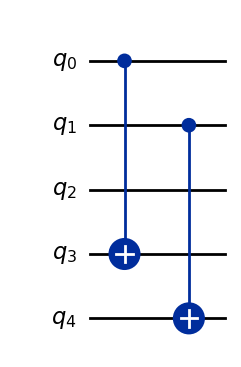

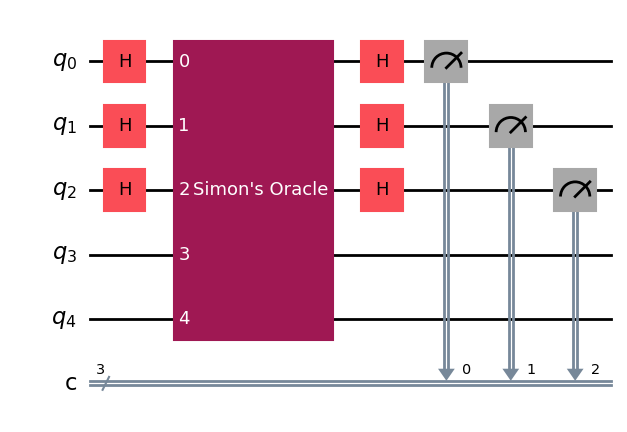

Counts: {'010': 10062, '001': 9977, '000': 9976, '011': 9985}


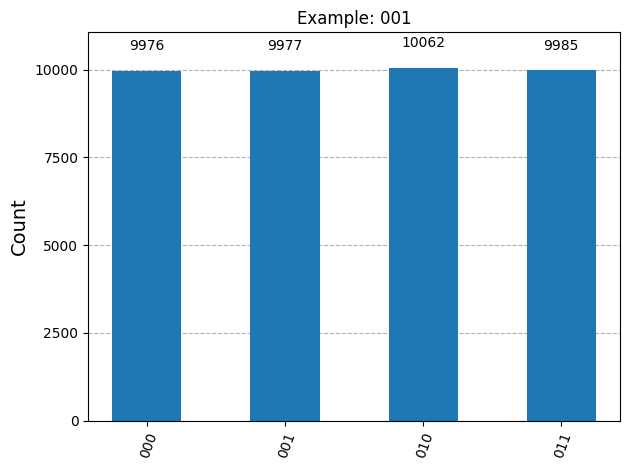

In [6]:
# Example usage case = "001"
n = 3
m = 2
case = "001"

oracle = simon_oracle(case)
qc = simon_algorithm(oracle)
display(oracle.draw(output="mpl"))
display(qc.draw(output="mpl"))

# Run on simulator
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc, shots = 40000).result()
counts = result.get_counts()
print("Counts:", counts)
plot_histogram(counts, title="Example: "+ case)

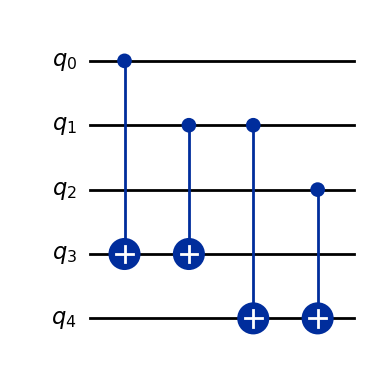

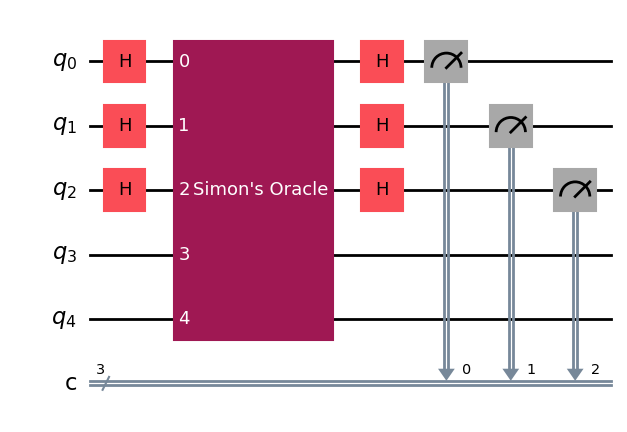

Counts: {'101': 10025, '000': 10129, '110': 9863, '011': 9983}


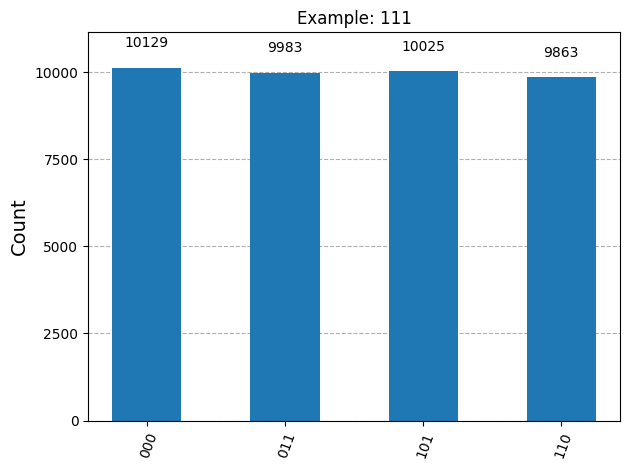

In [7]:
# Example usage case = "111"
n = 3
m = 2
case = "111"

oracle = simon_oracle(case)
qc = simon_algorithm(oracle)
display(oracle.draw(output="mpl"))
display(qc.draw(output="mpl"))

# Run on simulator
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc, shots = 40000).result()
counts = result.get_counts()
print("Counts:", counts)
plot_histogram(counts, title="Example: "+ case)

As expected, in all three examples we measure strings perpendicular (binary dot product zero) to the secret.